In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import json
%matplotlib inline

In [3]:
train = pd.read_csv('train.csv')

In [4]:
train.head()

,channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",1131660440785968503,"{""continent"": ""Asia"", ""subContinent"": ""Western...",1131660440785968503_1472830385,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472830385,1,1472830385
1,Organic Search,20160902,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",377306020877927890,"{""continent"": ""Oceania"", ""subContinent"": ""Aust...",377306020877927890_1472880147,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472880147,1,1472880147
2,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",3895546263509774583,"{""continent"": ""Europe"", ""subContinent"": ""South...",3895546263509774583_1472865386,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472865386,1,1472865386
3,Organic Search,20160902,"{""browser"": ""UC Browser"", ""browserVersion"": ""n...",4763447161404445595,"{""continent"": ""Asia"", ""subContinent"": ""Southea...",4763447161404445595_1472881213,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472881213,1,1472881213
4,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",27294437909732085,"{""continent"": ""Europe"", ""subContinent"": ""North...",27294437909732085_1472822600,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472822600,2,1472822600


In [5]:
# read train data and convert json columns to dataframe
raw = train
device = pd.DataFrame(raw["device"].apply(json.loads).tolist(),index = raw.index)
geo = pd.DataFrame(raw["geoNetwork"].apply(json.loads).tolist(),index = raw.index)
total = pd.DataFrame(raw["totals"].apply(json.loads).tolist(),index = raw.index)
traffic = pd.DataFrame(raw["trafficSource"].apply(json.loads).tolist(),index = raw.index)

In [6]:
#merge json info back to dataset 
js_col =  ['device', 'geoNetwork','totals','trafficSource']
raw = raw.drop(columns=js_col)
js_df = ['device','geo','total','traffic']
for i in js_df:
    data_name = i
    raw = pd.merge(raw,vars()[data_name],left_index=True,right_index=True)

In [12]:
raw.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId',
       'socialEngagementType', 'visitId', 'visitNumber', 'visitStartTime',
       'browser', 'browserSize', 'browserVersion', 'deviceCategory',
       'flashVersion', 'isMobile', 'language', 'mobileDeviceBranding',
       'mobileDeviceInfo', 'mobileDeviceMarketingName', 'mobileDeviceModel',
       'mobileInputSelector', 'operatingSystem', 'operatingSystemVersion',
       'screenColors', 'screenResolution', 'city', 'cityId', 'continent',
       'country', 'latitude', 'longitude', 'metro', 'networkDomain',
       'networkLocation', 'region', 'subContinent', 'bounces', 'hits',
       'newVisits', 'pageviews', 'transactionRevenue', 'visits', 'adContent',
       'adwordsClickInfo', 'campaign', 'campaignCode', 'isTrueDirect',
       'keyword', 'medium', 'referralPath', 'source'],
      dtype='object')

In [15]:
#keep pre-selected columns
keep_col = ['channelGrouping','fullVisitorId','visitNumber', 'visitId','visitStartTime',
           'browser','operatingSystem','deviceCategory','isMobile',
           'continent','country','subContinent','city','region','metro',
           'bounces', 'hits','newVisits','pageviews',
          'adContent','medium', 'isTrueDirect','transactionRevenue']
train_basic = raw[keep_col]
train_basic["bounces"] = train_basic["bounces"].fillna(0)
train_basic["newVisits"] = train_basic["newVisits"].fillna(0)
train_basic["isTrueDirect"] = train_basic["isTrueDirect"].fillna("False")
train_basic["transactionRevenue"] = train_basic["transactionRevenue"].fillna(0)

In [16]:
train_basic.head()

,channelGrouping,fullVisitorId,visitNumber,visitId,visitStartTime,browser,operatingSystem,deviceCategory,isMobile,continent,...,region,metro,bounces,hits,newVisits,pageviews,adContent,medium,isTrueDirect,transactionRevenue
0,Organic Search,1131660440785968503,1,1472830385,1472830385,Chrome,Windows,desktop,False,Asia,...,Izmir,(not set),1,1,1,1,NaN,organic,False,0
1,Organic Search,377306020877927890,1,1472880147,1472880147,Firefox,Macintosh,desktop,False,Oceania,...,not available in demo dataset,not available in demo dataset,1,1,1,1,NaN,organic,False,0
2,Organic Search,3895546263509774583,1,1472865386,1472865386,Chrome,Windows,desktop,False,Europe,...,Community of Madrid,(not set),1,1,1,1,NaN,organic,False,0
3,Organic Search,4763447161404445595,1,1472881213,1472881213,UC Browser,Linux,desktop,False,Asia,...,not available in demo dataset,not available in demo dataset,1,1,1,1,NaN,organic,False,0
4,Organic Search,27294437909732085,2,1472822600,1472822600,Chrome,Android,mobile,True,Europe,...,not available in demo dataset,not available in demo dataset,1,1,0,1,NaN,organic,True,0


## First, we plot the distribution of transaction revenue for each user. We can see that our dataset is highly inbalanced, user who never spend money in the store takes the majority.
## The plot below is also a good visualization for demonstrating the 80/20 rule. I.e., for many events, roughly 80% of the effects come from 20% of the causes.

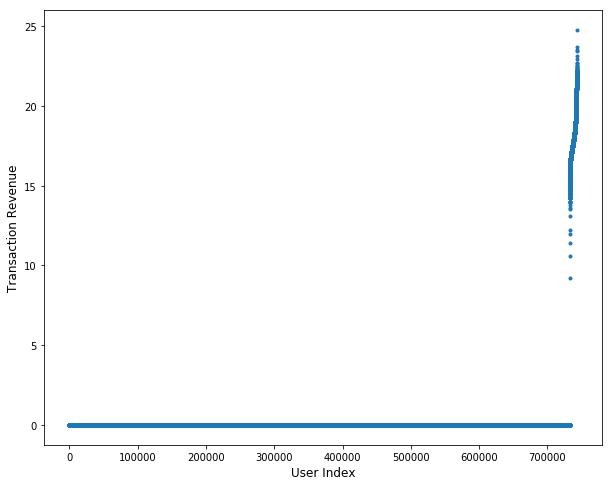

In [22]:
train_basic["transactionRevenue"] = train_basic["transactionRevenue"].astype('float')
gdf = train_basic.groupby("fullVisitorId")["transactionRevenue"].sum().reset_index()

plt.figure(figsize=(10,8))
plt.scatter(range(gdf.shape[0]), np.sort(np.log1p(gdf["transactionRevenue"].values)), marker= '.')
plt.xlabel('User Index', fontsize=12)
plt.ylabel('Transaction Revenue', fontsize=12)